<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-is-a-isochrone-map?" data-toc-modified-id="What-is-a-isochrone-map?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What is a isochrone map?</a></span></li><li><span><a href="#Draw-an-isochrone-map-with-OSMnx" data-toc-modified-id="Draw-an-isochrone-map-with-OSMnx-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Draw an isochrone map with OSMnx</a></span><ul class="toc-item"><li><span><a href="#Download-and-prep-the-street-network" data-toc-modified-id="Download-and-prep-the-street-network-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Download and prep the street network</a></span></li><li><span><a href="#Plots-nodes-you-can-reach-on-foot-within-each-time" data-toc-modified-id="Plots-nodes-you-can-reach-on-foot-within-each-time-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plots nodes you can reach on foot within each time</a></span></li><li><span><a href="#Plot-the-time-distances-as-isochrones" data-toc-modified-id="Plot-the-time-distances-as-isochrones-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot the time-distances as isochrones</a></span></li><li><span><a href="#Or,-plot-isochrones-as-buffers-to-get-more-faithful-isochrones-than-convex-hulls-can-offer" data-toc-modified-id="Or,-plot-isochrones-as-buffers-to-get-more-faithful-isochrones-than-convex-hulls-can-offer-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer</a></span></li></ul></li></ul></div>

# What is a isochrone map?

An isochrone map is a visual representation of which areas you can reach within a given time or distance.

In most locations, all directions cannot be traversed equally. Two endpoints may be five miles from a starting location, but one could take much longer to travel to. This is due to factors outside of simple distance, including geography, traffic, and routes available to specific modes of transport (e.g. train lines, bike paths, ski slopes).

Isochrone maps calculate these factors to identify what areas can be reached within a certain time limit, allowing businesses or individuals to accurately account for commutes, delivery times, or other essential travel metrics.

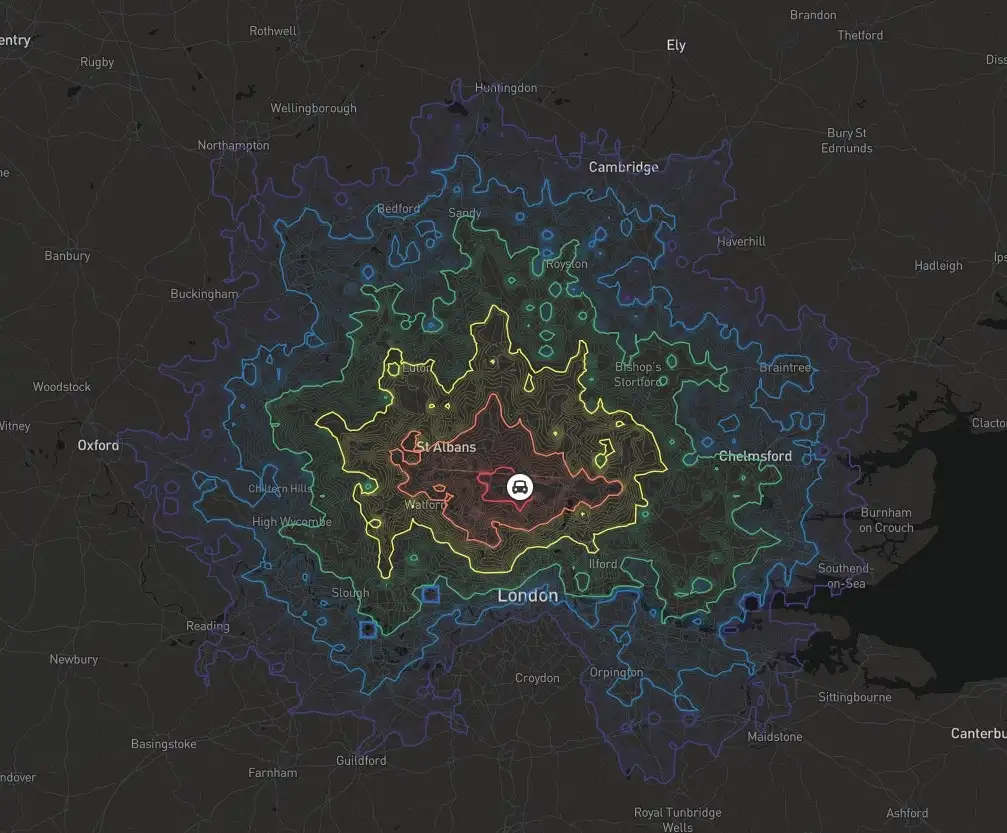

# Draw an isochrone map with OSMnx

Author: Geoff Boeing, Yiyi He

How far can you travel on foot in 15 minutes?

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import os
import pickle

%matplotlib inline
ox.__version__

'1.9.4'

Let's take a look at an example.

In [2]:
# configure the place, network type, trip times, and travel speed

# define a bounding box
bbox = [33.86,-84.40,33.82,-84.34]

# specify a place name
place = {"city": "Athens", "state": "Georgia"}

# specify network type
network_type = "walk"

# specify travel time thresholds in minutes
trip_times = [5, 10, 15, 20, 25]  # in minutes

# specify travel speed
travel_speed = 4.5  # walking speed in km/hour

## Download and prep the street network

In [3]:
# download the street network using bounding box
G = ox.graph_from_bbox(north=33.86, south=33.84, east=-84.36, west=-84.40, network_type=network_type)

/var/folders/mw/90tjblbd21x0d066xkhcl8xc0000gn/T/ipykernel_17734/2957741226.py:2: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north=33.86, south=33.84, east=-84.36, west=-84.40, network_type=network_type)
/var/folders/mw/90tjblbd21x0d066xkhcl8xc0000gn/T/ipykernel_17734/2957741226.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north=33.86, south=33.84, east=-84.36, west=-84.40, network_type=network_type)


Save graph to local directory

In [4]:
with open('../Lectures/G.pk', 'wb') as handle:
    pickle.dump(G, handle, protocol=2)

In [5]:
G_raw = pickle.load(open('../Lectures/G.pk', 'rb'))

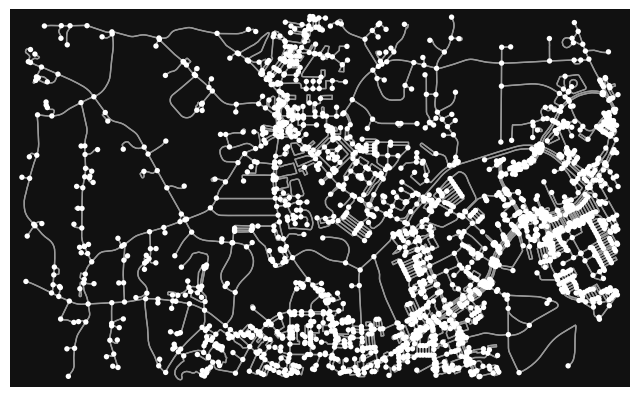

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
# Draw the graph
ox.plot_graph(G_raw)

In [8]:
# find the centermost node
gdf_nodes = ox.graph_to_gdfs(G_raw, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.nearest_nodes(G_raw, x[0], y[0])

# Project graph to UTM
G = ox.project_graph(G_raw)

In [14]:
for i, j, data in G.edges.data():
    print(i, j, data)
    break

69113686 5424306281 {'osmid': 9235538, 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 47.558}


In [15]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

Let's take a look at the attributes for the edges in the graph

In [17]:
for i, j, data in G.edges.data():
    print(i, j, data)
    break

69113686 5424306281 {'osmid': 9235538, 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 47.558, 'time': 0.6341066666666667}


## Plots nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [18]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="viridis", start=0, return_hex=True)

/var/folders/mw/90tjblbd21x0d066xkhcl8xc0000gn/T/ipykernel_17734/1321570539.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="viridis", start=0, return_hex=True)


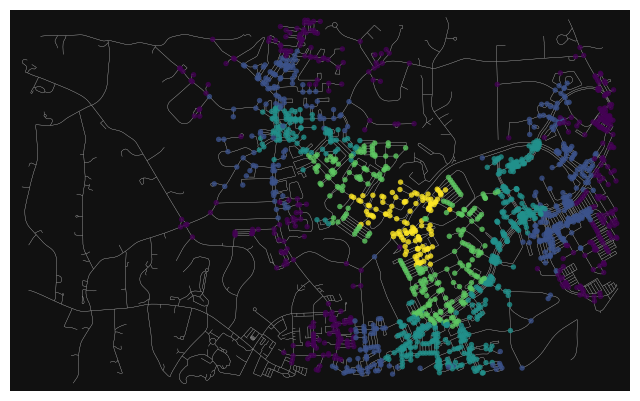

In [19]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [20]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

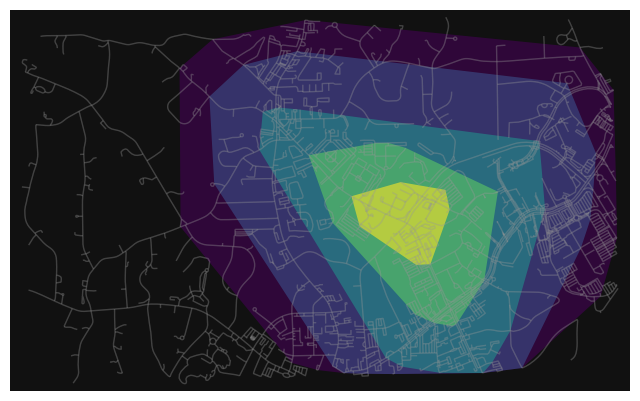

In [21]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

In [22]:
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index("id")
    
    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
        edge_lines.append(edge_lookup)
    
    break

In [23]:
def make_iso_polys(G, edge_buff=0.0001, node_buff=0.0001, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [24]:
# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=0.0001, node_buff=0.0001, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

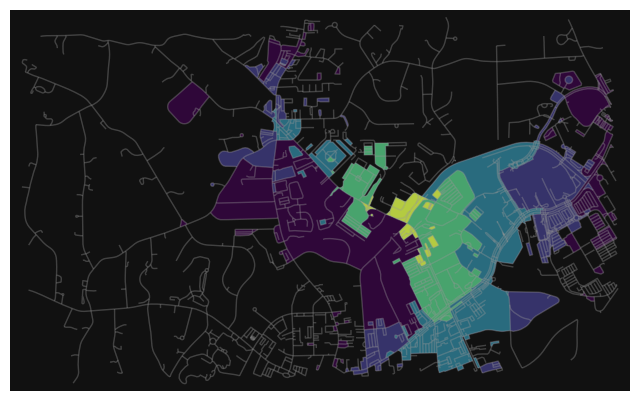

In [25]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()